用1层隐藏层的神经网络分类二维数据

欢迎来到第3周的编程作业。 现在是时候建立你的第一个神经网络了，它将具有一层隐藏层。 你将看到此模型与你使用逻辑回归实现的模型之间的巨大差异。

你将学到如何：

实现具有单个隐藏层的2分类神经网络
使用具有非线性激活函数的神经元，例如tanh
计算交叉熵损失
实现前向和后向传播

In [ ]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent
# np.random.seed()函数用于生成指定随机数。
# seed()被设置了之后，np,random.random()可以按顺序产生一组固定的数组，
# 如果使用相同的seed()值，则每次生成的随机数都相同，
# 如果不设置这个值，那么每次生成的随机数不同。

加载数据集

In [ ]:
X, Y = load_planar_dataset()

使用matplotlib可视化数据集。 
数据看起来像是带有一些红色（标签y = 0）和一些蓝色（y = 1）点的“花”。 
我们的目标是建立一个适合该数据的分类模型。

In [ ]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y.reshape(X[0,:].shape), s=40, cmap=plt.cm.Spectral)

现在你有：
   - 包含特征（x1，x2）的numpy数组（矩阵）X
   - 包含标签（红色：0，蓝色：1）的numpy数组（向量）Y。

首先让我们深入地了解一下我们的数据。

练习：数据集中有多少个训练示例？ 另外，变量“ X”和“ Y”的“shape”是什么？

In [ ]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = X.shape
shape_Y = Y.shape

m = shape_X[1]  # training set size
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))


3- 简单Logistic回归
在构建完整的神经网络之前，首先让我们看看逻辑回归在此问题上的表现。 你可以使用sklearn的内置函数来执行此操作。 运行以下代码以在数据集上训练逻辑回归分类器。

In [ ]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

由于数据集不是线性可分类的，因此逻辑回归效果不佳。 让我们试试是否神经网络会做得更好吧!

4- 神经网络模型
从上面我们可以得知Logistic回归不适用于“flower数据集”。现在你将训练带有单个隐藏层的神经网络。

建立神经网络的一般方法是：
1.定义神经网络结构（输入单元数，隐藏单元数等）。
2.初始化模型的参数
3.循环：

实现前向传播
计算损失
后向传播以获得梯度
更新参数（梯度下降）
我们通常会构建辅助函数来计算第1-3步，然后将它们合并为nn_model()函数。一旦构建了nn_model()并学习了正确的参数，就可以对新数据进行预测。


4.1- 定义神经网络结构
练习：定义三个变量：
     - n_x：输入层的大小
     - n_h：隐藏层的大小（将其设置为4）
     - n_y：输出层的大小

提示：使用shape来找到n_x和n_y。 另外，将隐藏层大小硬编码为4。

In [ ]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0] # size of input layer, 2
    n_h = 4
    n_y = Y.shape[0] # size of output layer, 1
    ### END CODE HERE ###
    
    layer_size = {
        "n_x": n_x,
        "n_h": n_h,
        "n_y": n_y
    }

    return layer_size

In [ ]:
X_assess, Y_assess = layer_sizes_test_case()
# X: (5, 3)   Y: (2, 3)
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

4.2- 初始化模型的参数
练习：实现函数 initialize_parameters()。

说明：

请确保参数大小正确。 如果需要，也可参考上面的神经网络图。
使用随机值初始化权重矩阵。
     - 使用：np.random.randn（a，b）* 0.01随机初始化维度为（a，b）的矩阵。
将偏差向量初始化为零。
     - 使用：np.zeros((a,b)) 初始化维度为（a，b）零的矩阵。

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    ### END CODE HERE ###
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [ ]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

4.3- 循环
问题：实现forward_propagation（）。

说明：

在上方查看分类器的数学表示形式。
你可以使用内置在笔记本中的sigmoid()函数。
你也可以使用numpy库中的np.tanh（）函数。
必须执行以下步骤：
     1.使用parameters [“ ..”]从字典“ parameters”（这是initialize_parameters（）的输出）中检索出每个参数。
     2.实现正向传播，计算Zf1, Af1, Zf2和Af2（所有训练数据的预测结果向量）。
向后传播所需的值存储在cache中,  cache将作为反向传播函数的输入。

In [ ]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """

    # dim_tuple = layer_sizes(X, Y)
    # params = initialize_parameters(dim_tuple[0], dim_tuple[1], dim_tuple[2])
    
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # forward propagation
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [ ]:
X_assess, parameters = forward_propagation_test_case()

A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

练习：实现compute_cost（）以计算损失的值。

In [ ]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
     ### START CODE HERE ### (≈ 2 lines of code)
    logprobs = Y * np.log(A2) + (1-Y) * np.log(1-A2)
    cost = -1/m * np.sum(logprobs)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [ ]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

In [ ]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache["A1"]
    A2 = cache["A2"]
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 = A2 - Y
    dW2 = 1 / m * np.dot(dZ2,A1.T)
    db2 = 1 / m * np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = np.dot(W2.T,dZ2) * (1-np.power(A1,2))
    dW1 = 1 / m * np.dot(dZ1,X.T)
    db1 = 1 / m * np.sum(dZ1,axis=1,keepdims=True)
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## END CODE HERE ###

    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [ ]:
def nn_model(X, Y, n_h, iterate_times = 10000, print_cost = False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(3)
    layer_size = layer_sizes(X, Y)
    n_x = layer_size["n_x"]
    n_y = layer_size["n_y"]

    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Loop (gradient descent)
    for i in range(iterate_times):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [ ]:
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, iterate_times=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

In [30]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    # np.round: 返回浮点数的四舍五入值
    predictions = np.round(A2)
    ### END CODE HERE ###
    
    return predictions

In [31]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219440
Cost after iteration 9000: 0.218553


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

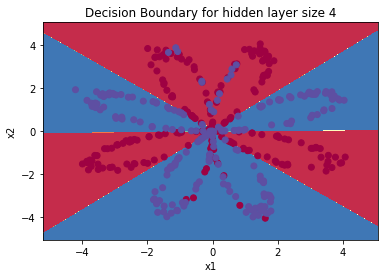

In [33]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, iterate_times= 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [34]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 10 hidden units: 90.25 %
Accuracy for 20 hidden units: 90.5 %


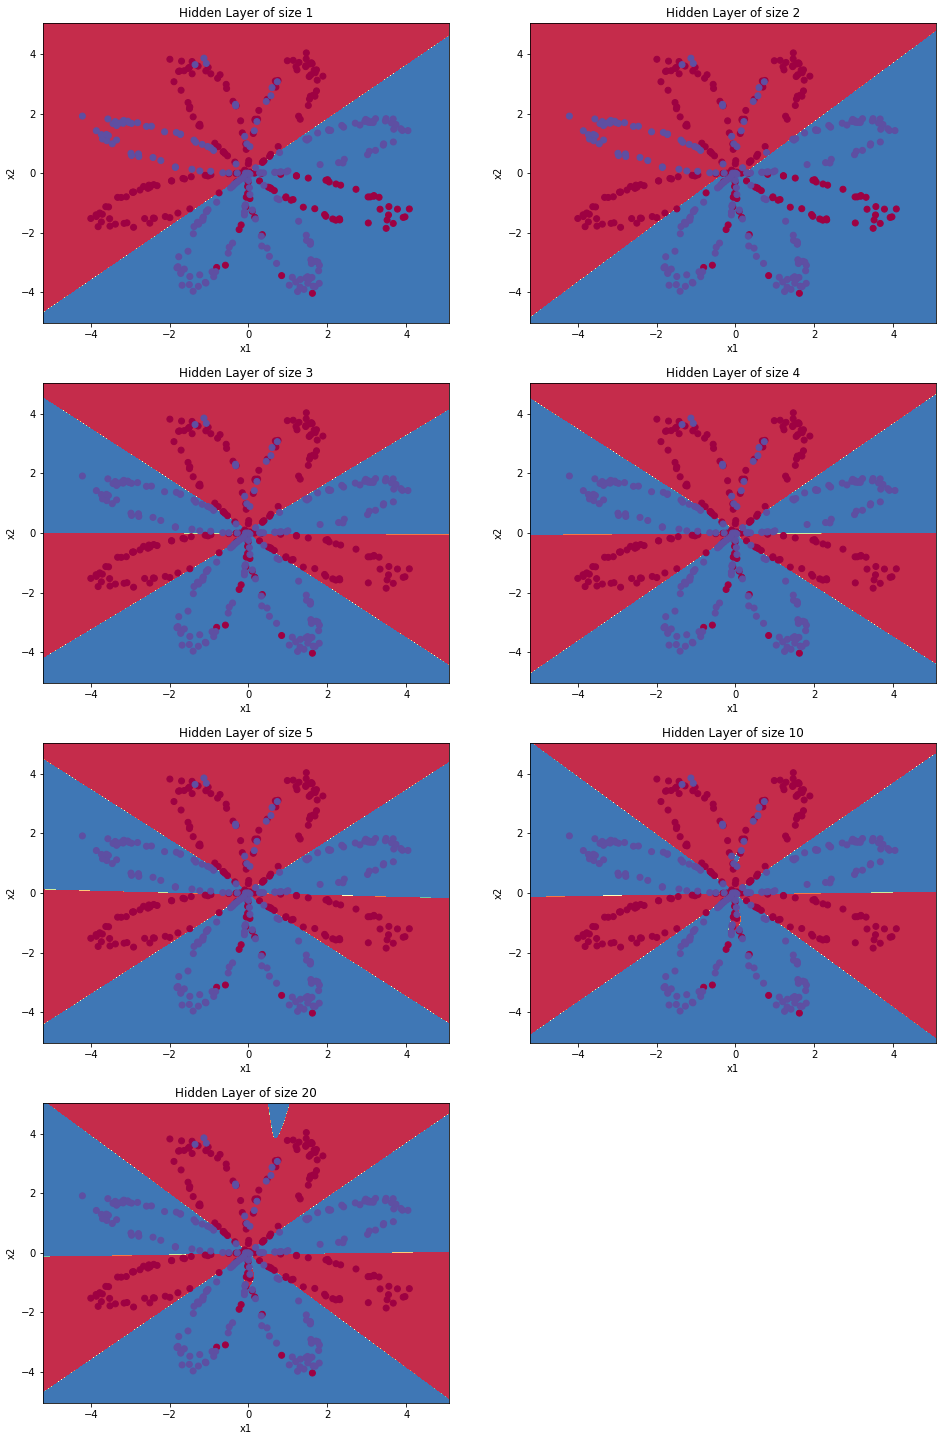

In [36]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 10, 20]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, iterate_times= 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))